# Chapter 20 - Blankenbach - Case1a

This notebook implements the Blankenbacch Case1a isoviscous thermal convection benchmark.

This notebook puts all of the major function definitions into separate source files and contains only the high-level program code.

In [2]:
# Import necessary packages
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")

# note that we import pyplot last to avoid a name conflict with grid.
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

In [3]:
function initial_conditions!(markers::Markers)
    rho = markers.scalarFields["rho"]
    eta = markers.scalarFields["eta"]
    T = markers.scalarFields["T"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        mr = ((mx-2.5e5)^2 + (my-2.5e5)^2)^0.5
        # my initial misunderstanding of the problem setup:
        # markers.rho[i] = mx >= 200e3 && mx <= 300e3 ? 3200. : 3300.
        markers.scalars[rho,i] = mr < 1.0e5 ? 3200. : 3300.
        markers.scalars[eta,i] = mr < 1.0e5 ? 1e20 : 1e21 
        markers.scalars[T,i] = mr < 1.0e5 ? 1300. : 1000.
    end
end

initial_conditions! (generic function with 1 method)

## Model setup

Boundary conditions are insulating on the sides, fixed temperature top and bottom.

Initial condition is:
$$
T(x,y) = T_{surf} + \frac{(T_{btm}-T_{surf})}{H} y + dT\cos(\frac{\pi x}{W}) \sin(\frac{\pi y}{H})
$$

Note that the origin of the coordinate system is in the upper right. $y$ increases downward, $x$ increases rightward.

In [4]:
function blankenbach_initial_conditions!(markers::Markers,Ttop,Tbtm,W,H)
    eta = markers.scalarFields["eta"]
    T = markers.scalarFields["T"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        # T(x,y) = Tsurf + (Tbtm-Tsurf)/H * y + dT*cos(pi*x/W)
        markers.scalars[eta,i] = 1e23
        markers.scalars[T,i] = Ttop + (Tbtm-Ttop)/H*my + 100.0*cos(pi*mx/W)*sin(pi*my/H)
    end
end

function compute_nusselt(grid::CartesianGrid,T,Tbcval,kThermal)
    
end

function run_blankenbach_case1a(nstep=1)
    nx = 257
    ny = 257
    W = 1e6
    H = 1e6
    
    gx = 0.0
    gy = 10.0
    alpha = 2.5e-5; # thermal expansivity

    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    Tbcval = [0.,0.,273.,1273.]   
    
    markx = 5
    marky = 5
    seconds_in_year = 3.15e7
    plot_interval = 100e6*seconds_in_year # plot interval in seconds
    end_time = 1e9*seconds_in_year
    dtmax = plot_interval
    
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["T","rho","eta"],["material"] ; nmx=markx,nmy=marky,random=true)
    println("Initial condition...")
    @time blankenbach_initial_conditions!(markers,Tbcval[3],Tbcval[4],W,H)

    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 5.0 .*ones(grid.ny,grid.nx);
    Cp = 1250. .* ones(grid.ny,grid.nx);
    H = zeros(grid.ny,grid.nx);

    time = 0.0
    iout=0
    last_plot = 0.0

    local rho
    local eta_s
    local T
    local dt
    local dTmax
    local dTemp
    local Tnew
    local Tlast
    
    nu_values=zeros(0)
    time_values=zeros(0)
    
    output_dir = "case1a"
    for itime in 1:nstep
        rho_var = markers.scalarFields["rho"]
        T_var = markers.scalarFields["T"]
        for i in 1:markers.nmark
            markers.scalars[rho_var,i] = 4000.0*(1.0-alpha*(markers.scalars[T_var,i]-Tbcval[3]))
        end
        
        # Get density and viscosity from the markers.
        rho_new,eta_s_new = marker_to_basic_node(markers,grid,["rho","eta"]);

        if time > 0.0
            nanind = findall(isnan.(rho_new))
            rho_new[nanind] = rho[nanind]
            eta_s_new[nanind] = eta_s[nanind]     
        end

        rho   = copy(rho_new)
        eta_s = copy(eta_s_new) 

        eta_n = viscosity_to_cell_centers(grid,eta_s_new)

        # assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s_new,eta_n,rho_new,bc,gx,gy)
        solution = L\R
        vx,vy,P = unpack(solution,grid;ghost=true)
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        dt = compute_timestep(grid,vxc,vyc;dtmax=dtmax)

        # get temperature at cell centers
        Tlast, = marker_to_cell_center(markers,grid,["T",])
        Tlast = ghost_temperature_center(grid,Tlast,Tbcval);
        if time > 0.0
            nanind = findall(isnan.(Tlast))
            Tlast[nanind] = T[nanind]
        end

        dTmax = Inf
        while dTmax >= 20.0 # limit maximum temperature change
            # assemble and solve the energy equation
            println("Trying with timestep ",dt)
            L,R = assemble_energy_equation_center(grid,rho,Cp,kThermal,H,Tlast,dt,Tbcval);
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbcval);

            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))
            println("dTmax=",dTmax," dt=",dt)
            dt = min(dt,dTmax < 20.0 ? dt : dt/2)
        end
        # compute Nu
        dTdy = (T[2,:]-T[1,:])/(grid.yc[2]-grid.yc[1])
        kdTdy = kThermal[1,1]*dTdy
        qcond = kThermal[1,1]*(Tbcval[4]-Tbcval[3])/grid.H
        Nu = mean(kdTdy)/qcond;
        
        append!(nu_values,Nu)
        append!(time_values,time)
        
        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node

        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")

        if time == 0.0 || time - last_plot >= plot_interval
            last_plot = time 
            name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
            vn = velocity_to_basic_nodes(grid,vxc,vyc)

        visualization(grid,rho,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
            name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
            visualization(markers,time/seconds_in_year;filename=name)
            iout += 1
        end

        move_markers_rk2!(markers,grid,vxc,vyc,dt)
        time += dt
        println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr Nu=",Nu," ",extrema(Tnew[2:end-1,2:end-1]))
    end
    return nu_values, time_values
end

run_blankenbach_case1a (generic function with 2 methods)

In [8]:
@time nu,t = run_blankenbach_case1a(5)

Creating Markers...
  0.026342 seconds (19 allocations: 91.336 MiB)
Initial condition...
  0.067381 seconds
Trying with timestep 7.7113053819827e13
dTmax=0.5393966648305195 dt=7.7113053819827e13
Finished Step 1 time=2.4480334545976827 Myr Nu=1.0147007512907813 (274.35918328913516, 1271.6415672374187)
Trying with timestep 7.575059280334462e13
dTmax=0.34376650539684306 dt=7.575059280334462e13
Finished Step 2 time=4.852814178513385 Myr Nu=0.9956338030650294 (274.3236911090975, 1271.6590058500835)
Trying with timestep 7.44366527637738e13
dTmax=0.2691965955493174 dt=7.44366527637738e13
Finished Step 3 time=7.21588252022049 Myr Nu=0.9938678751860336 (274.31154657543595, 1271.6700517366503)
Trying with timestep 7.316869497701084e13
dTmax=0.303053795957112 dt=7.316869497701084e13
Finished Step 4 time=9.538698233776389 Myr Nu=0.9948624882401681 (274.3030985206205, 1271.6788212517251)
Trying with timestep 7.194439099638555e13
dTmax=0.2940896587516022 dt=7.194439099638555e13
Finished Step 5 time=

([1.0147007512907813, 0.9956338030650294, 0.9938678751860336, 0.9948624882401681, 0.9963861282215097], [0.0, 7.7113053819827e13, 1.5286364662317162e14, 2.2730029938694544e14, 3.0046899436395625e14])

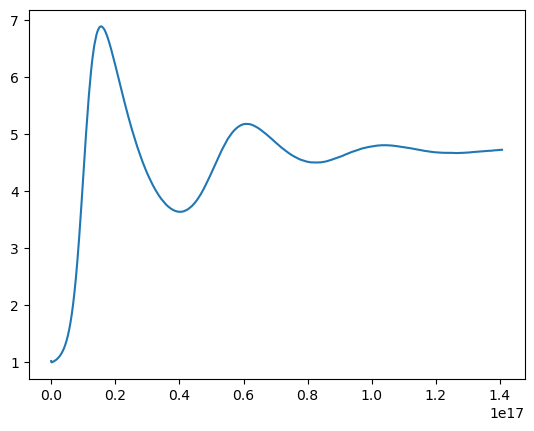

In [6]:
figure()
plot(t,nu)
show()

In [7]:
nu[end]

4.720084308967778